# Práctica 1: Integración Numérica

**Román Alberto Vélez Jiménez**

CU: 165462

**Problema:**
Sea $F(x, y) := (x^2 + y - 10)^2 + (x + y^2 -12)^2 -100$ y sea $\mathcal{G} = \{(x, y) \in \mathbb{R}^{2} | F(x, y) \leq 0\}$ la región del plano definida por la gráfica de $F$. 

In [1]:
# imports
import numpy as np
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# for estochastic modeling
from scipy.stats import multivariate_normal

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# implicit function
def F(x, y):
    return (x**2 + y - 10)**2 + (x + y**2 - 12)**2 - 100

In [3]:
# plot filled level curves
def plot_level_curve(f, x_range, y_range, levels):
    x = np.linspace(*x_range)
    y = np.linspace(*y_range)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    plt.contour(X, Y, Z, levels=levels)
    # pretty up the plot
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Contour Plot')

La región $\mathcal{G}$ se le conoce como la [Himmelblau's function](!https://en.wikipedia.org/wiki/Himmelblau%27s_function). Su forma para valores $(x,y)$ donde $F(x,y) \leq 0$ se muestra en la siguiente figura:

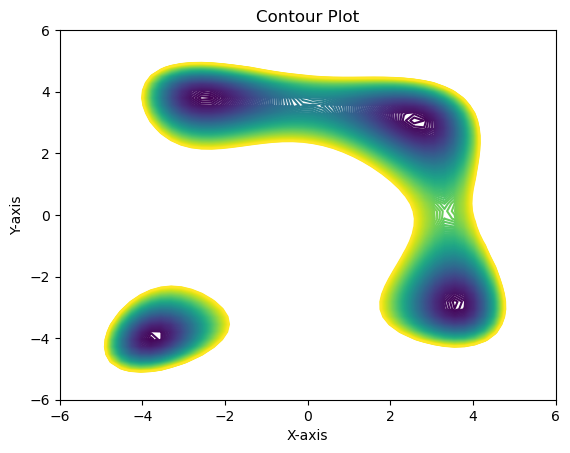

In [4]:
# plot level curves
x_range = (-6, 6)
y_range = (-6, 6)
levels = np.arange(-100, 1, 1)
plot_level_curve(F, x_range, y_range, levels)

Observamos una geometría discountinua en el plano cartesiano.

# Parte 1: Área de $\mathcal{G}$

In [5]:
# montecarlo integration
def montecarlo_integration(f, lp_range, N, seed=8, verbose=False):
    # fix random number generator
    rng = np.random.default_rng(seed=8)
    # generate random points
    xy_range = rng.uniform(*lp_range, (N, 2))
    # estimate the area
    total_area = (lp_range[1] - lp_range[0])**2
    region_percentage = np.mean(f(xy_range[:, 0], xy_range[:, 1]) <= 0)
    area = total_area * region_percentage

    # plot the points
    if verbose:
        plot_level_curve(f, lp_range, lp_range, levels=np.array([0, 0.1]))
        plt.scatter(xy_range[:, 0], xy_range[:, 1], c=f(xy_range[:, 0], xy_range[:, 1]) <= 0)
        # add title
        plt.title(f"Montecarlo Integration with N={N}")
        # add annotation bottom left
        plt.annotate(f"Area: {np.round(area, 4)}", xy=(lp_range[0], lp_range[0]), xycoords="data")
        plt.show()
    
    return area

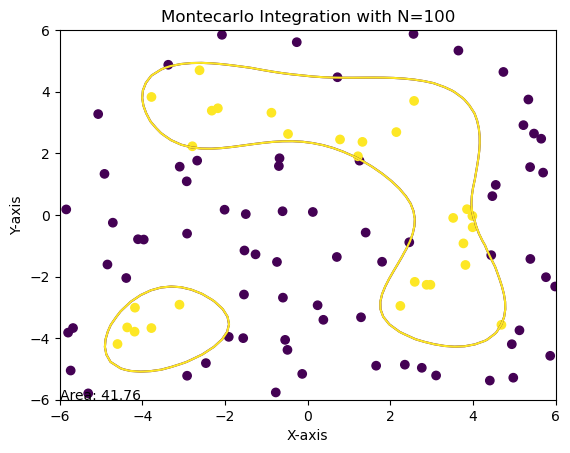

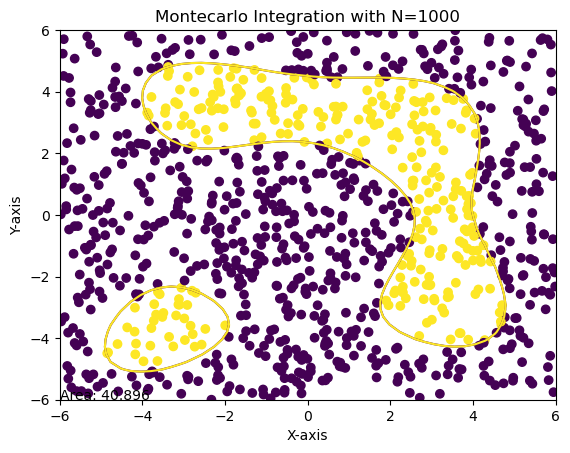

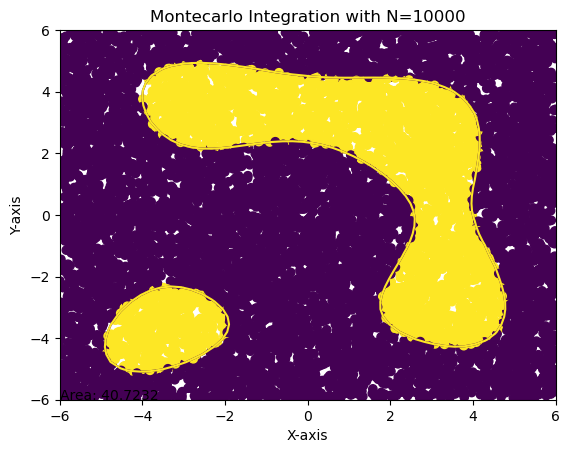

In [6]:
# test the function for 10^2, 10^2, ..., 10^8 points
N = np.logspace(2, 8, 7, dtype=int)
areas = [montecarlo_integration(F, x_range, n, verbose=(n<=1e+4)) for n in N]

In [7]:
# print the results
for n, area in zip(N, areas):
    print(f"N={n}: {area}")

N=100: 41.76
N=1000: 40.895999999999994
N=10000: 40.7232
N=100000: 39.10176
N=1000000: 38.83032
N=10000000: 38.7893232
N=100000000: 38.76904368


In [8]:
# to dataframe
df_areas = pd.DataFrame({"N": N, "Area": areas}).set_index("N").T
df_areas

N,100,1000,10000,100000,1000000,10000000,100000000
Area,41.76,40.896,40.7232,39.10176,38.83032,38.789323,38.769044


In [9]:
# to latex
print(df_areas.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{rrrrrrr}
\toprule
100 & 1000 & 10000 & 100000 & 1000000 & 10000000 & 100000000 \\
\midrule
41.7600 & 40.8960 & 40.7232 & 39.1018 & 38.8303 & 38.7893 & 38.7690 \\
\bottomrule
\end{tabular}



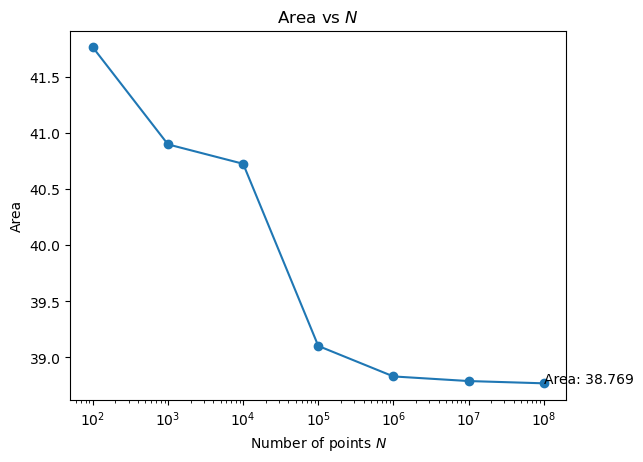

In [10]:
# plot the areas vs N with x log scale as bar plot
plt.plot(N, areas)
plt.scatter(N, areas)
# add value of the area
plt.annotate(f"Area: {np.round(areas[-1], 4)}", xy=(N[-1], areas[-1]), xycoords="data")
plt.xscale("log")
plt.xlabel("Number of points $N$")
plt.ylabel("Area")
plt.title("Area vs $N$")
plt.show()

Notamos que el área estimada está alrededor de 38 unidades. Es interesante ver que, aunque se aumente en un órden el número de puntos, el área estimada no cambia mucho. Esto quizá se debe a que la función es muy irregular y no se puede estimar bien el área con un método estocástico. Además, el método de Montecarlo tiene un error $\mathcal{O}(1/\sqrt{n})$ por lo que para ganar un dígito de precisión se requiere incrementar en 2 órdenes el número de puntos, véase Optimización, [Erick Palacios](!https://itam-ds.github.io/analisis-numerico-computo-cientifico/1.computo_cientifico/1.7/Integracion_numerica.html).

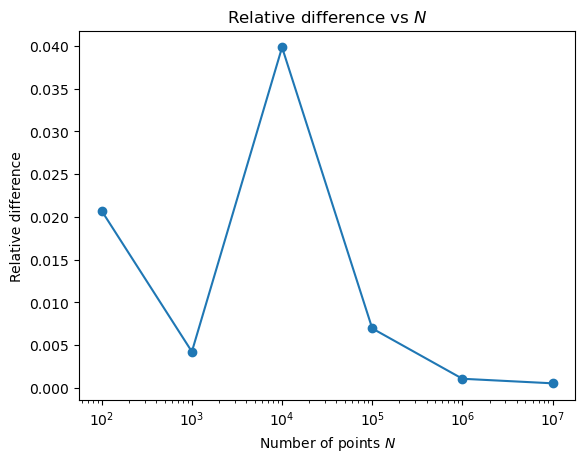

In [11]:
# get the relative difference between areas (lagged)
diff = np.abs(np.diff(areas)/areas[:-1])
diff 

# plot the relative difference
plt.plot(N[:-1], diff)
plt.scatter(N[:-1], diff)
plt.xscale("log")
plt.xlabel("Number of points $N$")
plt.ylabel("Relative difference")
plt.title("Relative difference vs $N$")
plt.show()


# Parte 2: Integración recursiva

In [12]:
def grid_division(lp_range, h=2):
    # generate grids for a given range
    x_min, x_max, y_min, y_max = lp_range
    x_step = (x_max - x_min) / h
    y_step = (y_max - y_min) / h
    grids = []
    # generate h^2 points for the grids
    for i in range(h):
        for j in range(h):
            x1 = x_min + i * x_step
            x2 = x_min + (i + 1) * x_step
            y1 = y_min + j * y_step
            y2 = y_min + (j + 1) * y_step
            grids.append((x1, x2, y1, y2))
    return grids

def check_sign_pos(signs):
    list_signs = [sign > 0 for sign in signs]
    return all(list_signs)

def check_sign_neg(signs):
    list_signs = [sign <= 0 for sign in signs]
    return all(list_signs)

def integrate_grid(list_sign, grid):
    if check_sign_pos(list_sign):
        # if the values are positive, it means that the grid is outside the implicit function, so the area is 0
        return 0.0
    else:
        # heuristic: if the signs still have different values, then the grid is going to be integrated
        x1, x2, y1, y2 = grid
        return (x2 - x1) * (y2 - y1)

def unpack_grid(grid):
    x1, x2, y1, y2 = grid
    return [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]

def integrate_recursive_armonic(F, grids, depth):
    # global variable to save the extended grids
    global grid_extended

    # finished recursion
    if len(grids) == 0:
        return 0.0    

    # max recursion --> integrate
    if depth == 0:
        area = 0.0
        for grid in grids:
            points = unpack_grid(grid)
            list_sign = [np.sign(F(x, y)) for x, y in points]
            area += integrate_grid(list_sign, grid)
        return area
    
    # recursive
    grid = grids.pop()
    # get points
    points = unpack_grid(grid)
    # check sign of points
    list_sign = [np.sign(F(x, y)) for x, y in points]
    # integrate
    if check_sign_pos(list_sign) or check_sign_neg(list_sign):
        return integrate_grid(list_sign, grid) + integrate_recursive_armonic(F, grids, depth)
    else:
        new_grids = grid_division(grid, h=2)
        # save to grid extended
        grid_extended.extend(new_grids)
        return integrate_recursive_armonic(F, new_grids, depth-1) + integrate_recursive_armonic(F, grids, depth)

## Recursión con profundidad

In [13]:
# get grid division
lp_range = (-6, 6, -6, 6)
grids = grid_division(lp_range, h=10)
grid_extended = grids.copy()

# integrate
area = integrate_recursive_armonic(F, grids, depth=8)
print(f"Area: {area}")

Area: 38.80043701171875


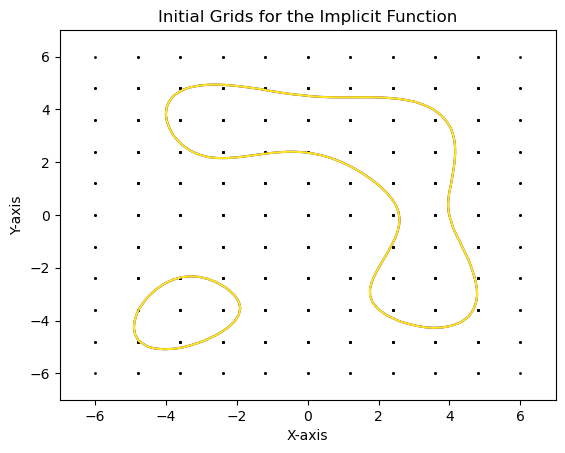

In [14]:
# plot grids
grids = grid_division(lp_range, h=10)
plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
# plot points in the grid
for grid in grids:
    x1, x2, y1, y2 = grid
    plt.scatter([x1, x1, x2, x2], [y1, y2, y1, y2], c="black", s=1)
# pretty up the plot
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Initial Grids for the Implicit Function")
plt.show()


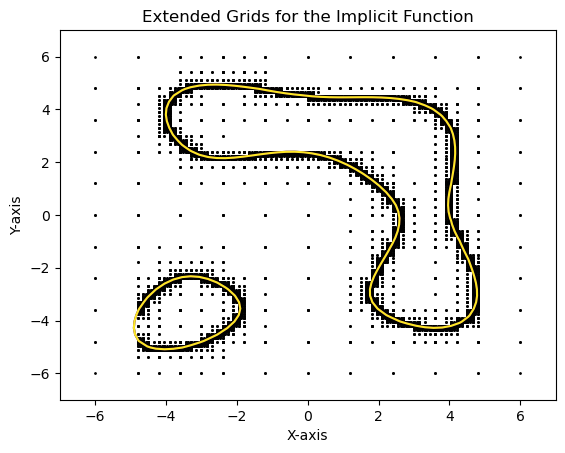

In [15]:
# plot all the new grids
plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
# plot points in the extended grid
for grid in grid_extended:
    x1, x2, y1, y2 = grid
    plt.scatter([x1, x1, x2, x2], [y1, y2, y1, y2], c="black", s=1)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Extended Grids for the Implicit Function")
plt.show()

## Recursión con red amplia

In [27]:
# get grid division
lp_range = (-6, 6, -6, 6)
grids = grid_division(lp_range, h=50)
grid_extended = grids.copy()

# integrate
area = integrate_recursive_armonic(F, grids, depth=2)
print(f"Area: {area}")

Area: 40.2984000000003


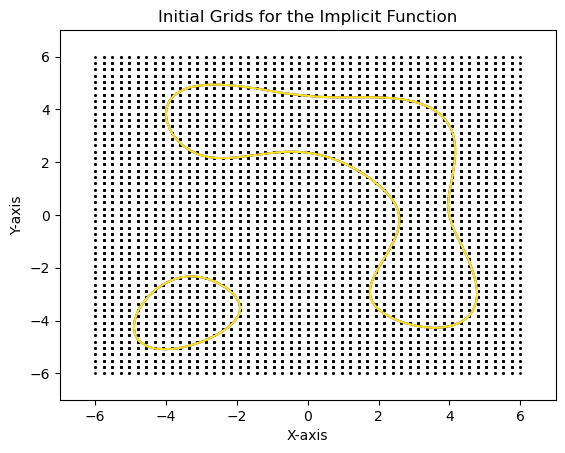

In [17]:
# plot grids
grids = grid_division(lp_range, h=50)
plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
# plot points in the grid
for grid in grids:
    x1, x2, y1, y2 = grid
    plt.scatter([x1, x1, x2, x2], [y1, y2, y1, y2], c="black", s=1)
# pretty up the plot
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Initial Grids for the Implicit Function")
plt.show()


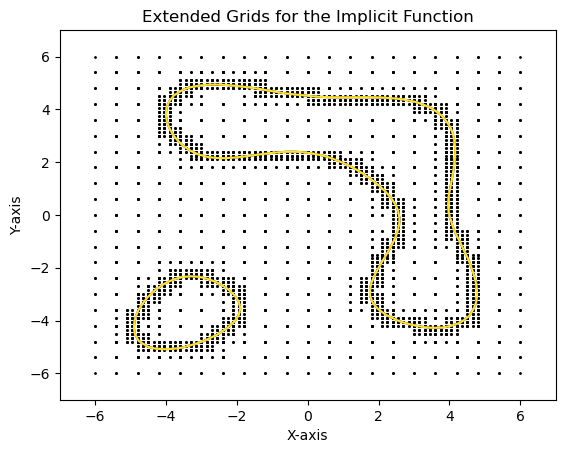

In [18]:
# plot all the new grids
plot_level_curve(F, x_range, y_range, levels=np.array([0, 0.1]))
# plot points in the extended grid
for grid in grid_extended:
    x1, x2, y1, y2 = grid
    plt.scatter([x1, x1, x2, x2], [y1, y2, y1, y2], c="black", s=1)
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Extended Grids for the Implicit Function")
plt.show()

Al tener que $\mathcal{G}$ es una geometría irregular, se tiene una mejor precisión y casi mismo tiempo de máquina al tener más profundidad en la recursión que tamaño de red. Esto se sustenta que para el primer caso el área estimada es de 38.8004 y para el segundo caso es de 40.2984. Además, el tiempo de máquina para el primer caso es de 0.3 segundos y para el segundo caso es de 0.2 segundos, siendo casi lo mismo en ambos casos.

# Parte 3: Probabilidades sobre $\mathcal{G}$

*Sub problema:* calcular la probabilidad que un punto $\underline{x} \in \mathcal{G}$ donde $\underline{x} \sim \mathcal{N}_{2}(\underline{\mu}, \Sigma)$, donde $\mu_{x} = \mu_{y} \in \{-5, -4, \dots, 5\}$ y $\Sigma = \begin{pmatrix} 2 & 0 \\ 0 & 2 \end{pmatrix}$. Es decir, calcular $\mathbb{P}[\underline{x} \in \mathcal{G}]$.

## Parte 3a: integral teórica

La integral sería la siguiente:
$$
\int_{(x, y) \in \mathcal{G}} f(x, y) dx \ dy.
$$ 

Donde $f(x, y) = \frac{1}{2 \pi \sqrt{|\Sigma|}} \exp \left( -\frac{1}{2} (\underline{x} - \underline{\mu})^{T} \Sigma^{-1} (\underline{x} - \underline{\mu}) \right)$.

## Parte 3b: Explicación

Al muestrear puntos aleatorios en el espacio de entrada, se puede estimar el área de la región de interés usando el método de Montecarlo. Teóricamente esto se puede gracias a la [Ley de los Grandes Números de Borel](!https://en.wikipedia.org/wiki/Law_of_large_numbers), la cuál establece que la media de una muestra aleatoria converge a la media de la distribución de la cual se muestrea. En este caso, se muestrean puntos aleatorios en el espacio de entrada y se calcula el porcentaje de puntos que caen dentro de la región de interés. Este porcentaje es la probabilidad.

Formalmente esto es: 
$$
\lim_{n \to \infty} \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}_{\mathcal{G}}(\underline{x}_{i}) = \mathbb{P}[\underline{x} \in \mathcal{G}], a.s.
$$

Donde $\mathbb{1}_{\mathcal{G}}(\underline{x}_{i})$ es la indicadora de que el punto $\underline{x}_{i}$ cae dentro de la región de interés $\mathcal{G}$ y $a.s.$ significa que la convergencia es [casi segura](!http://stanford.edu/~lanhuong/refresher/notes/probstat-section2.pdf).

## Parte 3c: Estimación numérica de la probabilidad

In [19]:
# get multivariate normal distribution using scipy
def multinorm_dist(x, mu, sigma):
    return multivariate_normal.pdf(x, mean=mu, cov=sigma)

In [20]:
def plot_with_points(f, points, prop, lp_range, mu):
    plot_level_curve(f, lp_range, lp_range, levels=np.array([0, 0.1]))
    plt.scatter(
        points[:, 0], points[:, 1],
        c=prop
    )
    plt.title(f"N={points.shape[0]}, mu = {mu}")
    plt.annotate(f"Proba: {100 * np.round(np.mean(prop), 2)}%", xy=(lp_range[0], lp_range[0]), xycoords="data")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.show()

def montecarlo_integration_binormal(f, points, mu, sigma, lp_range, verbose=False):
    prop = f(points[:, 0], points[:, 1]) <= 0
    area = np.mean(prop)

    if verbose:
        plot_with_points(f, points, prop, lp_range, mu)
    
    return area

def generate_data(N, mus, sigma, seed=8):
    rng = np.random.default_rng(seed=seed)
    dict_possibilities = {}

    # generate grid of N points for each mu
    print(f"Generating Data...")
    for n in N:
        dict_rnd_multinormal = {}
        for mu in mus:
            x_y_samples = np.random.multivariate_normal(
                mean=np.array([mu, mu]), cov=sigma, size=n
            )
            dict_rnd_multinormal[f"x_{mu}"] = {
                "x": x_y_samples,
                "mu": np.array([mu, mu]),
                "sigma": sigma
            }
        dict_possibilities[f"N_{n}"] = dict_rnd_multinormal

    return dict_possibilities

def estimate_probabilities(N, mus, dict_possibilities, lp_range):
    # montecarlo integration for binomial distributions
    dict_probas = {}

    print(f"Estimating probas...")
    for n in N:
        dict_probas[f"N_{n}"] = {}
        for mu in mus:
            # montecarlo integration
            dict_probas[f"N_{n}"][f"mu_{mu}"] = montecarlo_integration_binormal(
                f=F,
                points=dict_possibilities[f"N_{n}"][f"x_{mu}"]["x"],
                mu=dict_possibilities[f"N_{n}"][f"x_{mu}"]["mu"],
                sigma=dict_possibilities[f"N_{n}"][f"x_{mu}"]["sigma"],
                lp_range=lp_range,
                verbose=np.logical_and(n>1e+2, n<=1e+3) # only for one kid of n
            )

    return dict_probas

def transform_to_dataframe(dict_probas):
    data = []

    for N, inner_dict in dict_probas.items():
        for mu, proba in inner_dict.items():
            n_value = int(N.split('_')[1])
            mu_value = int(mu.split('_')[1])
            data.append([mu_value, n_value, proba])

    df = pd.DataFrame(data, columns=['mean', 'size', 'probs'])
    df = df.sort_values(by=['mean', 'size'], ignore_index=True)
    return df

def get_probas(N, mus, sigma, lp_range, seed=8):
    # generate data
    dict_possibilities = generate_data(N, mus, sigma, seed=seed)

    # estimate probabilities
    dict_probas = estimate_probabilities(N, mus, dict_possibilities, lp_range)

    # transform results to dataframe
    df = transform_to_dataframe(dict_probas)
    return df

Generating Data...
Estimating probas...


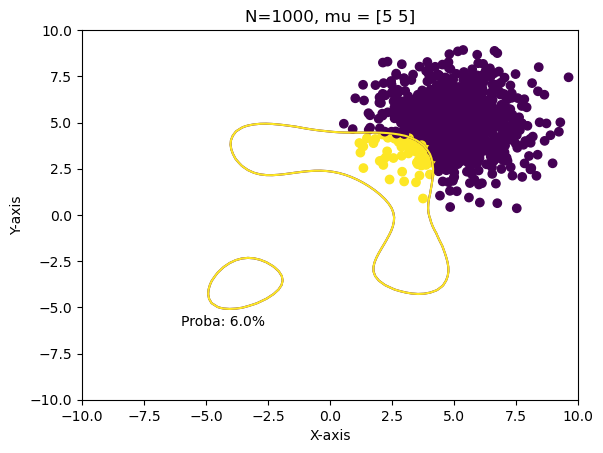

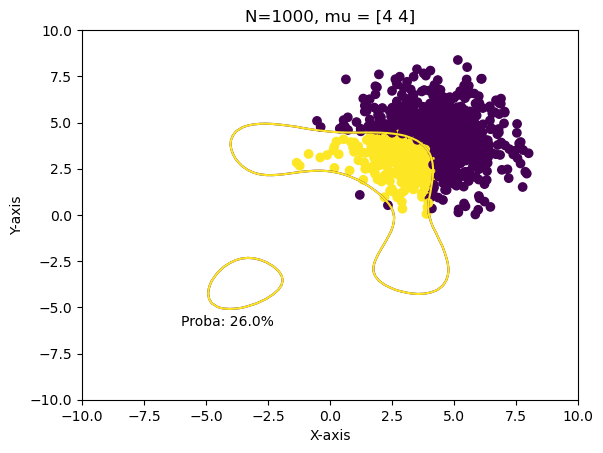

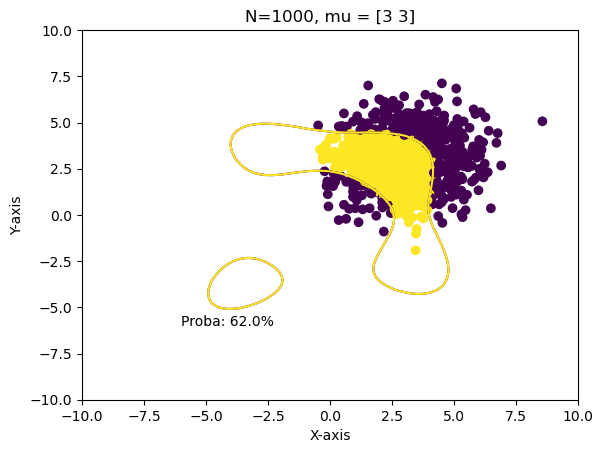

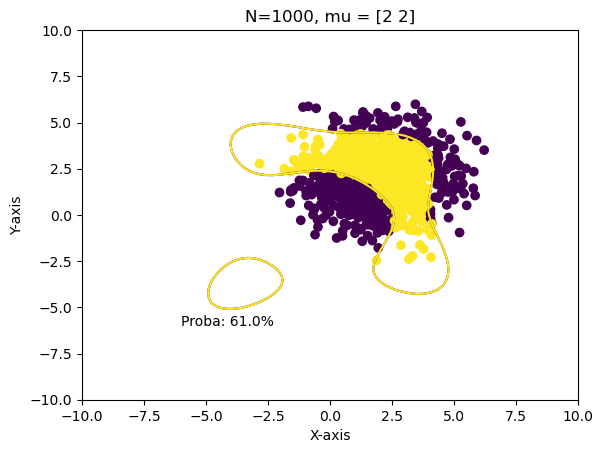

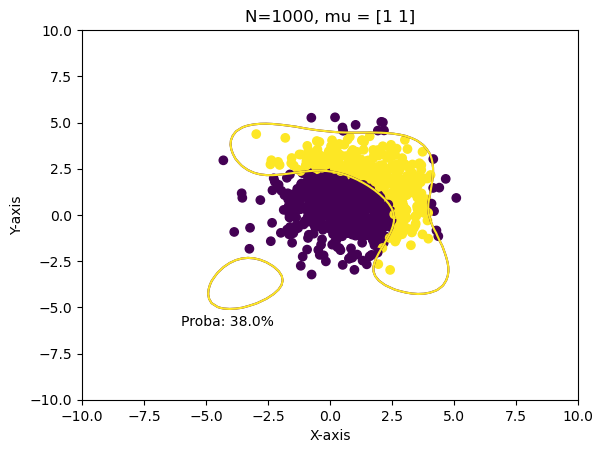

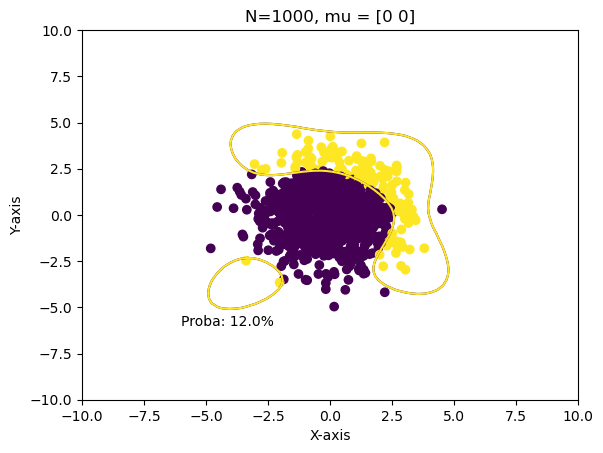

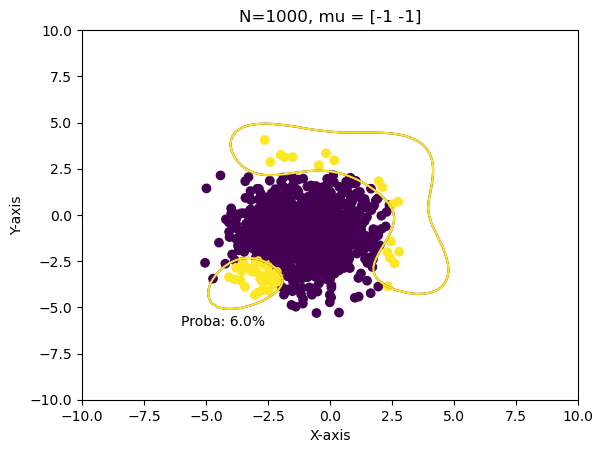

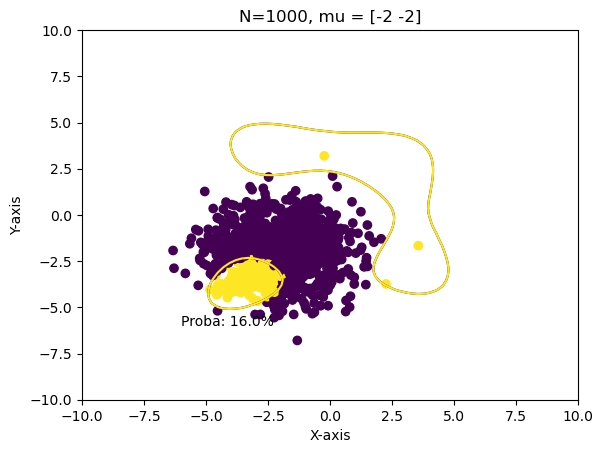

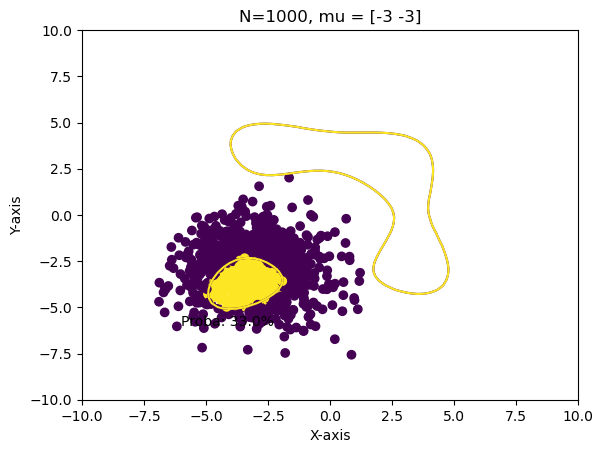

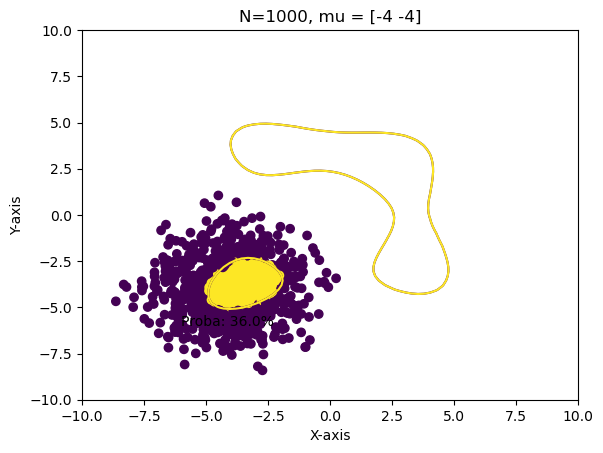

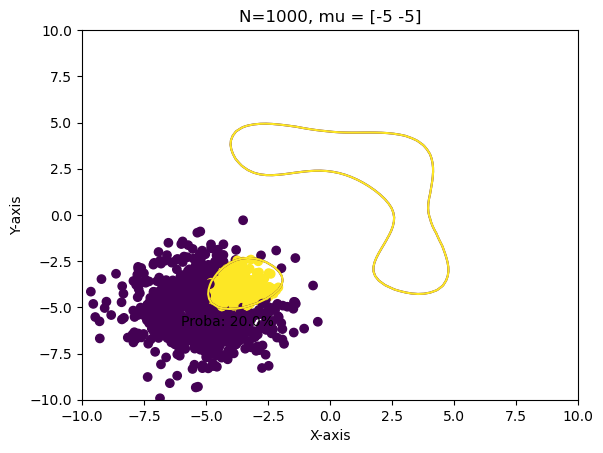

In [21]:
# estimate probabilities
N = np.logspace(2, 8, 7, dtype=int)
lp_range = (-6, 6)
mus = np.arange(5, -6, -1)
sigma = np.eye(2) * 2
df_probas = get_probas(N, mus, sigma, lp_range, seed=8)

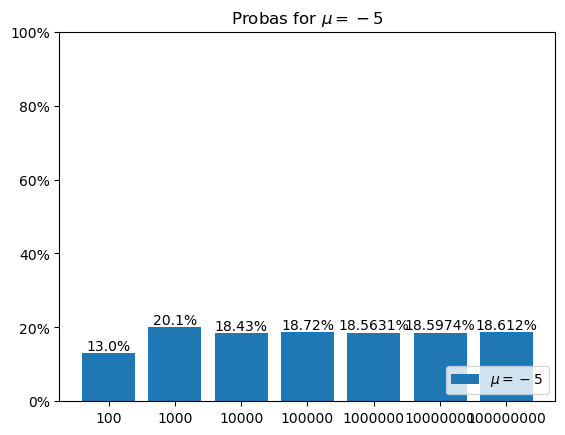

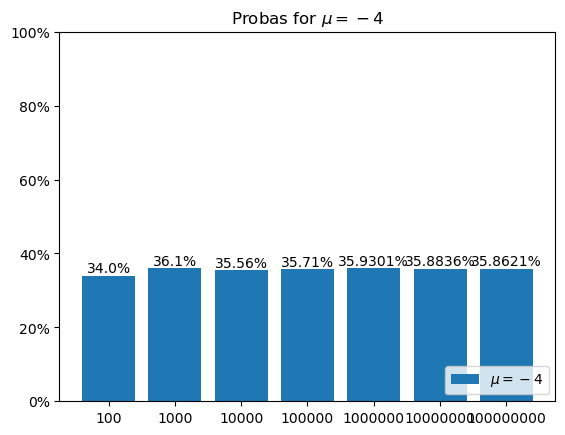

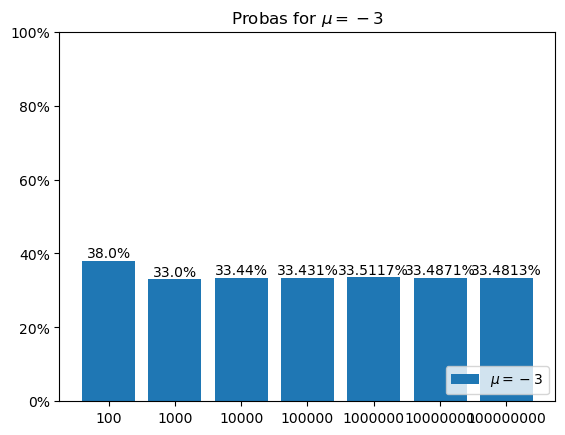

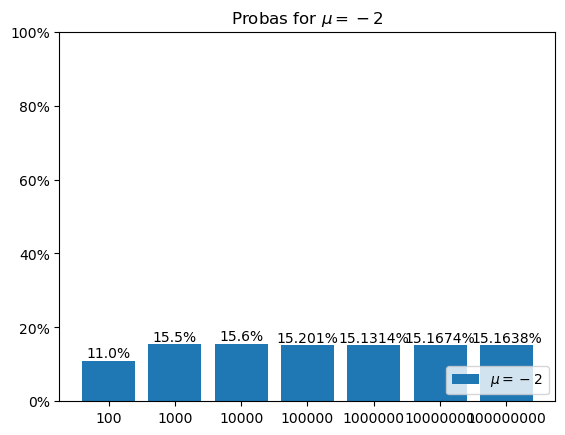

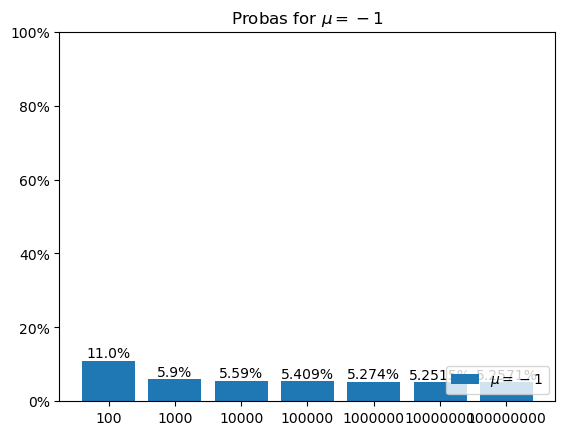

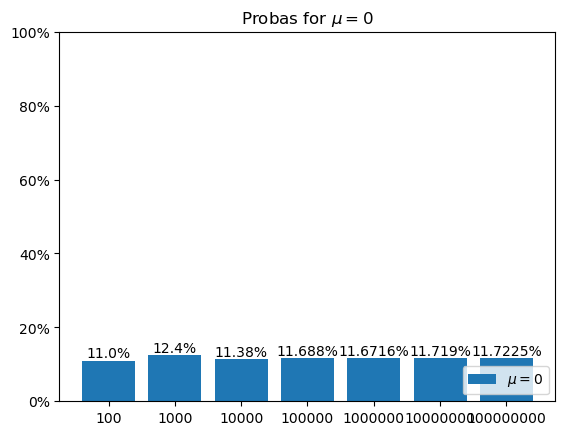

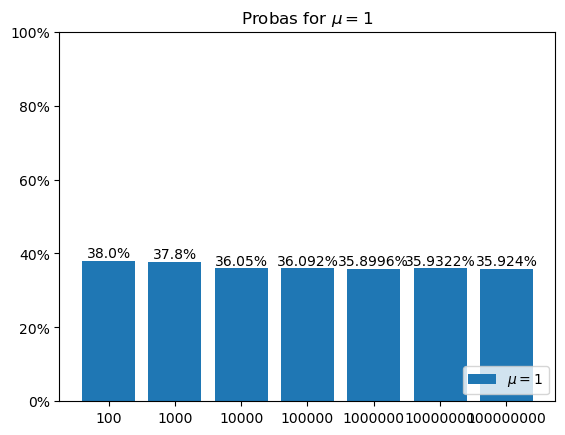

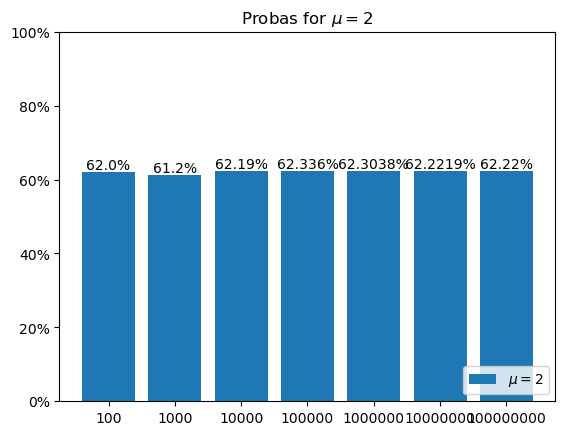

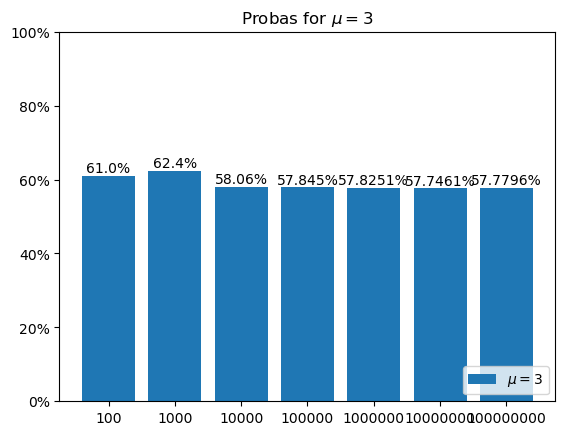

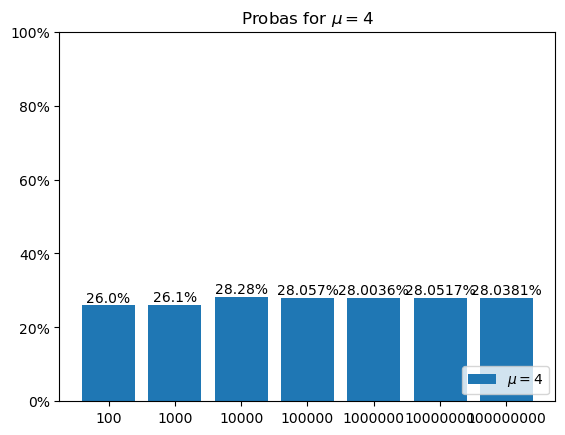

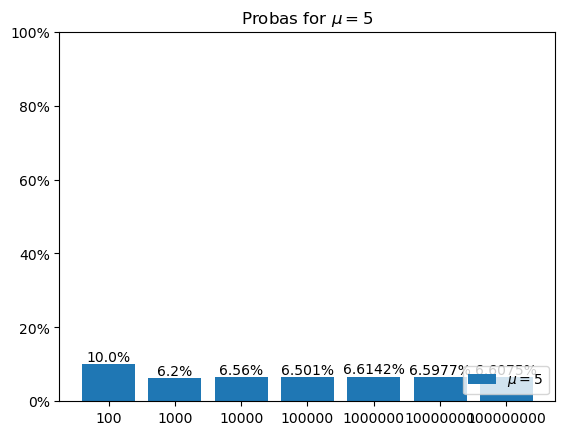

In [22]:
# generate a bar plot for each mu with N
df_plot = df_probas.copy()
df_plot["size"] = df_plot["size"].astype(str)

# plot
for group, gdf in df_plot.groupby("mean"):
    # plot bar plot
    plt.bar(gdf["size"], gdf["probs"], label=f"$\mu={group}$")
    # add value, add 4 decimals
    for i, v in enumerate(gdf["probs"]):
        plt.text(i, v, f"{np.round(100*v, 4)}%", ha="center", va="bottom")
    # y axis as percents
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x*100))))
    # y axis limit
    plt.ylim(0, 1)
    # add title
    plt.title(f"Probas for $\mu={group}$")
    # add legend bottom right
    plt.legend(loc="lower right")
    plt.show()
    

In [23]:
# pivot wider the dataframe
df_probas_wide = (
    df_probas.copy()
    .pivot(index="mean", columns="size", values="probs")
    .reset_index()
    .sort_values(by=["mean"], ignore_index=True, ascending=False)
    )
df_probas_wide


size,mean,100,1000,10000,100000,1000000,10000000,100000000
0,5,0.10,0.062,0.0656,0.06501,0.066142,0.065977,0.066075
1,4,0.26,0.261,0.2828,0.28057,0.280036,0.280517,0.280381
2,3,0.61,0.624,0.5806,0.57845,0.578251,0.577461,0.577796
3,2,0.62,0.612,0.6219,0.62336,0.623038,0.622219,0.622200
4,1,0.38,0.378,0.3605,0.36092,0.358996,0.359322,0.359240
5,0,0.11,0.124,0.1138,0.11688,0.116716,0.117190,0.117225
6,-1,0.11,0.059,0.0559,0.05409,0.052740,0.052515,0.052571
7,-2,0.11,0.155,0.1560,0.15201,0.151314,0.151674,0.151638
8,-3,0.38,0.330,0.3344,0.33431,0.335117,0.334871,0.334813
9,-4,0.34,0.361,0.3556,0.35710,0.359301,0.358836,0.358621


In [24]:
# probas wide to latex
print(df_probas_wide.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{rrrrrrrr}
\toprule
mean & 100 & 1000 & 10000 & 100000 & 1000000 & 10000000 & 100000000 \\
\midrule
5 & 0.1000 & 0.0620 & 0.0656 & 0.0650 & 0.0661 & 0.0660 & 0.0661 \\
4 & 0.2600 & 0.2610 & 0.2828 & 0.2806 & 0.2800 & 0.2805 & 0.2804 \\
3 & 0.6100 & 0.6240 & 0.5806 & 0.5785 & 0.5783 & 0.5775 & 0.5778 \\
2 & 0.6200 & 0.6120 & 0.6219 & 0.6234 & 0.6230 & 0.6222 & 0.6222 \\
1 & 0.3800 & 0.3780 & 0.3605 & 0.3609 & 0.3590 & 0.3593 & 0.3592 \\
0 & 0.1100 & 0.1240 & 0.1138 & 0.1169 & 0.1167 & 0.1172 & 0.1172 \\
-1 & 0.1100 & 0.0590 & 0.0559 & 0.0541 & 0.0527 & 0.0525 & 0.0526 \\
-2 & 0.1100 & 0.1550 & 0.1560 & 0.1520 & 0.1513 & 0.1517 & 0.1516 \\
-3 & 0.3800 & 0.3300 & 0.3344 & 0.3343 & 0.3351 & 0.3349 & 0.3348 \\
-4 & 0.3400 & 0.3610 & 0.3556 & 0.3571 & 0.3593 & 0.3588 & 0.3586 \\
-5 & 0.1300 & 0.2010 & 0.1843 & 0.1872 & 0.1856 & 0.1860 & 0.1861 \\
\bottomrule
\end{tabular}



In [25]:
# describe table and only get mean, std, max
(
    df_plot.groupby("mean")
    .describe()["probs"][["mean", "std"]]
    .rename({"mean": "probability"})
    # rename index
    .rename_axis("mu")
    .reset_index()
    .sort_index(ascending=False, ignore_index=True)
)

,mu,mean,std
0,5,0.070115,0.013258
1,4,0.275043,0.009980
2,3,0.589508,0.019237
3,2,0.620674,0.003973
4,1,0.365282,0.009415
5,0,0.116544,0.004222
6,-1,0.062402,0.021120
7,-2,0.146805,0.016334
8,-3,0.340502,0.017507
9,-4,0.355780,0.007163


Por la tabla anterior observamos que donde hay mayor incertidumbre en la estimación de la probabilidad es en $\underline{\mu} = (1, 1)$.

In [26]:
# get the probs for each mean for the maximum size
df_plot.sort_values(by=["mean", "size"], ascending=False).groupby("mean").head(1).reset_index(drop=True)

,mean,size,probs
0,5,100000000,0.066075
1,4,100000000,0.280381
2,3,100000000,0.577796
3,2,100000000,0.622200
4,1,100000000,0.359240
5,0,100000000,0.117225
6,-1,100000000,0.052571
7,-2,100000000,0.151638
8,-3,100000000,0.334813
9,-4,100000000,0.358621


Concluimos que la probabilidad que $\underline{x} \sim \mathcal{N}_{2}(\underline{\mu}, \Sigma)$ esté en $\mathcal{G}$ aumenta conforme disminuye la media casi llegando al dos y luego disminuye al disminuir la media. Su mínimo es en $\underline{\mu} = -(1, 1)^{T}$ y su máximo es en $\underline{\mu} = (2, 2)^{T}$. 